**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 1 - Perceptrón Multicapa

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

## Importación y análisis del dataset

Importamos las librerías

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import nltk
import re

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import pad_sequences, to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.under_sampling import NearMiss, RandomUnderSampler, ClusterCentroids

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

Importamos el dataset y lo almacenamos como un dataframe de pandas. Verificamos que no hayan datos faltantes y revisamos la distribución porcentual de los datos para verificar si el conjunto sea representativo

In [175]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()
print("\nAerolíneas:", dataset.airline.unique())
print("Opiniones:", dataset.airline_sentiment.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB

Aerolíneas: ['Virgin America' 'United' 'Southwest' 'Delta' 'US Airways' 'American']
Opiniones: ['neutral' 'positive' 'negative']


In [176]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa
        
        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')
    
    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)    
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

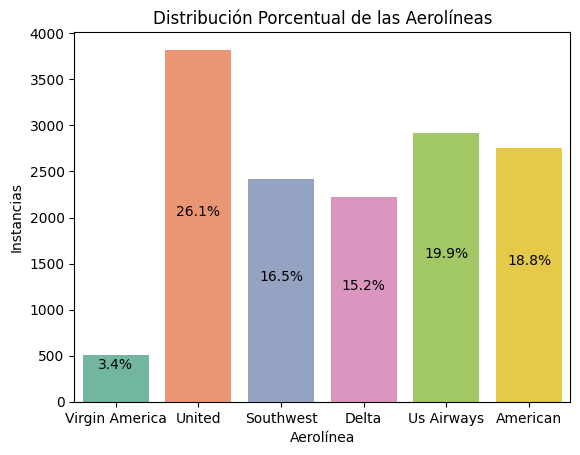

In [4]:
graficaDistribucion(dataset,"airline",["Virgin America", "United", "Southwest", "Delta", "Us Airways", "American"],"Aerolínea","Instancias","Distribución Porcentual de las Aerolíneas")

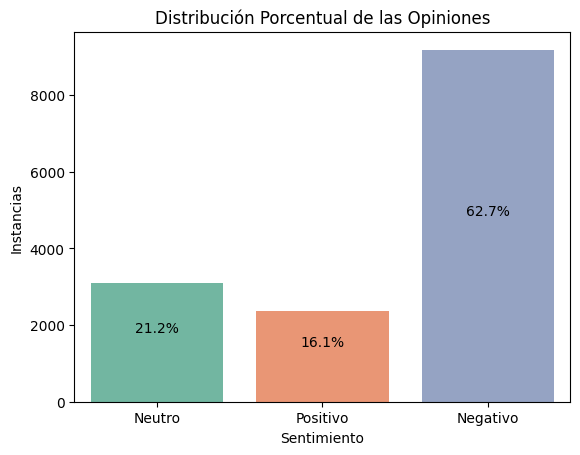

In [5]:
graficaDistribucion(dataset,"airline_sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones")

Hay un desbalanceo en las opiniones, la opinión positiva tiene el 62.7% y la negativa tiene el 16.1%, así que se implementarán técnicas de muestreo para balancear los datos.

## Preprocesamiento de los datos

Convertimos la salidas en vectores de binarios usando one hot encoding

In [9]:
#Se reemplaza negative por 0, neutral por 1 y positive por 2
numerical = dataset["airline_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2}).astype(int)
dataset["airline_sentiment_encoding"] = list(to_categorical(numerical, num_classes=3))

dataset.head()

,airline_sentiment,airline,text,airline_sentiment_encoding
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,"[0.0, 1.0, 0.0]"
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,"[0.0, 0.0, 1.0]"
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[0.0, 1.0, 0.0]"
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,"[1.0, 0.0, 0.0]"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,"[1.0, 0.0, 0.0]"


Procesamos y tokenizamos el texto para poder asignarle representaciones numéricas que se puedan utilizar en la Red Neuronal

In [10]:
nltk.download('stopwords')
palVacias = set(stopwords.words('english')) 
palRaiz = SnowballStemmer('english')
tokenizador = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")

#Además de stopwords, también eliminamos tags (@), links, y el # de los hashtags
usuarios = r"@\w*"
hashtags = r"#(\w+)"
links = r"http\S+"

#Los verbos conjugados en negación no reemplazan por "not" y no se eliminan
negaciones = r"\b(\w+)n't\b"

def preprocesamiento (tweet, stem=True):
    tweet = re.sub(usuarios, "", tweet)
    tweet = re.sub(hashtags, r"\1", tweet)
    tweet = re.sub(links, "", tweet)
    tweet = re.sub(negaciones, "not", tweet, flags=re.IGNORECASE)
    
    palabras = tokenizador.tokenize(tweet)
    texto = []
    
    #Convertimos el texto en un vector de palabras
    for palabra in palabras: 
        palabra_lower = palabra.lower()
        # Conserva "no" y "not" aunque sean stopwords
        if palabra_lower == "not" or palabra_lower == "no" or palabra_lower not in palVacias:
            #Convertir verbos conjugados a su raíz
            if stem:
                texto.append(palRaiz.stem(palabra).lower())
            else:
                texto.append(palabra_lower)
    
    return tokenizador.tokenize(" ".join(texto))

#Aplicar preprocesamiento a todo el dataset
dataset["token"] = dataset.text.map(preprocesamiento)
dataset.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,airline_sentiment,airline,text,airline_sentiment_encoding,token
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,"[0.0, 1.0, 0.0]",[said]
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,"[0.0, 0.0, 1.0]","[plus, ad, commerci, experi, tacki]"
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[0.0, 1.0, 0.0]","[not, today, must, mean, need, take, anoth, trip]"
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,"[1.0, 0.0, 0.0]","[realli, aggress, blast, obnoxi, entertain, gu..."
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,"[1.0, 0.0, 0.0]","[realli, big, bad, thing]"


Para la representación numérica usamos el algoritmo TF-IDF con una incidencia mínima de 5 y un vocabulario máximo de 2000

In [11]:
vectorizador = TfidfVectorizer(analyzer=lambda x: x, min_df=5, max_features=2000, token_pattern=None)
matriz = vectorizador.fit_transform(dataset["token"])
dataset["rep"] = [row.toarray().flatten().tolist() for row in matriz]
dataset.head()

,airline_sentiment,airline,text,airline_sentiment_encoding,token,rep
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,"[0.0, 1.0, 0.0]",[said],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,"[0.0, 0.0, 1.0]","[plus, ad, commerci, experi, tacki]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[0.0, 1.0, 0.0]","[not, today, must, mean, need, take, anoth, trip]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,"[1.0, 0.0, 0.0]","[realli, aggress, blast, obnoxi, entertain, gu...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,"[1.0, 0.0, 0.0]","[realli, big, bad, thing]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Como la distribución de los datos no está balanceada, implementamos la técnica del Submuestreo Cluster Centroids para equilibrar los datos.

In [ ]:
submuestreo = ClusterCentroids(sampling_strategy='auto', random_state=2025)

x = np.array(dataset["rep"].to_list(), dtype="float32")

#El submuestreo no recibe one hot encoding, convertir a etiquetas 0,1,2
y = dataset["airline_sentiment"].map({"negative": 0, "neutral": 1, "positive": 2}).astype(int)

xBal, yBal = submuestreo.fit_resample(x, y)

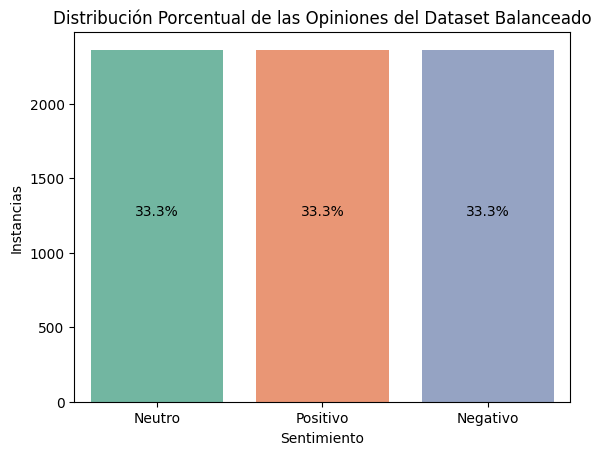

In [ ]:
datasetBal = pd.DataFrame({"tweet": [row.tolist() for row in xBal],"airline_sentiment": yBal})
graficaDistribucion(datasetBal,"airline_sentiment",["Neutro", "Positivo", "Negativo"],"Sentimiento","Instancias","Distribución Porcentual de las Opiniones del Dataset Balanceado")

## Creación y Entrenamiento de la Red Neuronal

Separamos el dataset en 2 conjuntos: 70% para el entrenamiento y 30% para la validación

In [234]:
#Se realiza nuevamente one hot encoding
datasetBal["airline_sentiment_encoding"] = list(
    to_categorical(datasetBal["airline_sentiment"], num_classes=3)
)

n = len(datasetBal)
cTrain = int(n*0.7) # 70% para entrenar y 30% para la validación
cTest = n-cTrain

print(f"N = {n} | Tamaño entrenamiento = {cTrain} | Tamaño prueba = {cTest}")

trainData, testData = train_test_split(datasetBal, train_size=cTrain, test_size=cTest, random_state=2025)
testData.head()

N = 7089 | Tamaño entrenamiento = 4962 | Tamaño prueba = 2127


,tweet,airline_sentiment,airline_sentiment_encoding
2981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2252905666828...",1,"[0.0, 1.0, 0.0]"
6464,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,"[0.0, 0.0, 1.0]"
6372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,"[0.0, 0.0, 1.0]"
4454,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[0.0, 1.0, 0.0]"
2054,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[1.0, 0.0, 0.0]"


Definimos la arquitectura de la red neuronal

In [230]:
def redNeuronal (entrada, salida):
    modelo = keras.Sequential([
        keras.Input(shape=(entrada,)),
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(salida, activation="softmax")
    ])
    opt = Adam(learning_rate=0.00001)
    modelo.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    
    return modelo

Definimos los parámetros de entrenamiento

In [231]:
def entrenamiento (xTrain, yTrain, xTest, yTest, modelo, epocas, lote, es):
    history = modelo.fit(
        xTrain, yTrain,
        validation_data = (xTest, yTest),
        epochs = epocas,
        batch_size = lote,
        callbacks=[es],
        verbose = 1,
        validation_split = 0.1
    )
    return history

Damos el formato correcto a los dataset y definimos los valores de los parámetros de entrenamiento

In [ ]:
xTrain = np.array(trainData["tweet"].to_list(), dtype="float32")
yTrain = np.array(trainData["airline_sentiment_encoding"].tolist())
xTest = np.array(testData["tweet"].to_list(), dtype="float32")
yTest = np.array(testData["airline_sentiment_encoding"].tolist())

epocas = 200
lote = 32
entrada = np.vstack(trainData.tweet.values).shape[1]
salida = np.vstack(trainData.airline_sentiment_encoding.values).shape[1]

print("Tamaño de la entrada:",entrada)
print("Tamaño de la salida:",salida)

llamadas = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

Tamaño de la entrada:  2000
Tamaño de la salida:  3


Realizamos el entrenamiento, con una cantidad de épocas determinada por el Early Stopping

In [ ]:
modelo = redNeuronal (entrada, salida)
resultado = entrenamiento(xTrain, yTrain, xTest, yTest, modelo, epocas, lote, llamadas)

resultados = {
    "Época": ["Primera", "Última"],
    "Loss": [resultado.history["loss"][0], resultado.history["loss"][-1]],
    "Val_Loss": [resultado.history["val_loss"][0], resultado.history["val_loss"][-1]],
    "Accuracy": [resultado.history["accuracy"][0], resultado.history["accuracy"][-1]],
    "Val_Accuracy": [resultado.history["val_accuracy"][0], resultado.history["val_accuracy"][-1]],
}

tabla = pd.DataFrame(resultados)
print(tabla)

Epoch 1/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3267 - loss: 1.2452 - val_accuracy: 0.3413 - val_loss: 1.2421
Epoch 2/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3394 - loss: 1.2396 - val_accuracy: 0.3484 - val_loss: 1.2375
Epoch 3/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3527 - loss: 1.2347 - val_accuracy: 0.3517 - val_loss: 1.2335
Epoch 4/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3561 - loss: 1.2310 - val_accuracy: 0.3564 - val_loss: 1.2297
Epoch 5/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3615 - loss: 1.2275 - val_accuracy: 0.3630 - val_loss: 1.2261
Epoch 6/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3573 - loss: 1.2238 - val_accuracy: 0.3686 - val_loss: 1.2226
Epoch 7/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3821 - loss: 1.2201 - val_accuracy: 0.3728 - val_loss: 1.2193
Epoch 8/200
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3825 - loss: 1.2166 - val_accu

Matriz de confusión de la última época

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


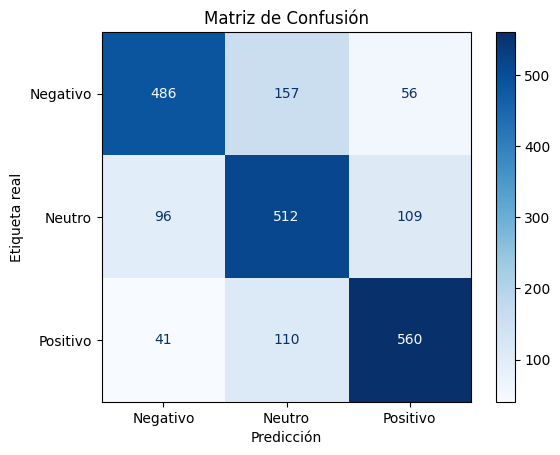

In [69]:
yPred = modelo.predict(xTest)

yPred_labels = np.argmax(yPred, axis=1)
yTest_labels = np.argmax(yTest, axis=1)

# Matriz de confusión
cm = confusion_matrix(yTest_labels, yPred_labels)
class_names = ['Negativo', 'Neutro', 'Positivo']

# Graficar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")

plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")

plt.show()

Accuracy de entrenamiento y validación

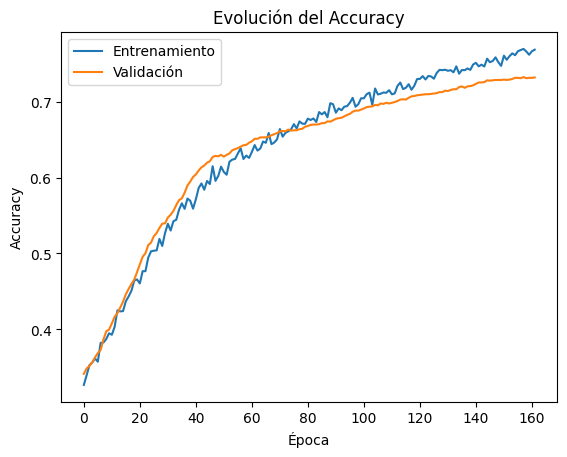

In [70]:
# Accuracy
plt.plot(resultado.history["accuracy"], label="Entrenamiento")
plt.plot(resultado.history["val_accuracy"], label="Validación")
plt.title("Evolución del Accuracy")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Pérdidas de entrenamiento y validación

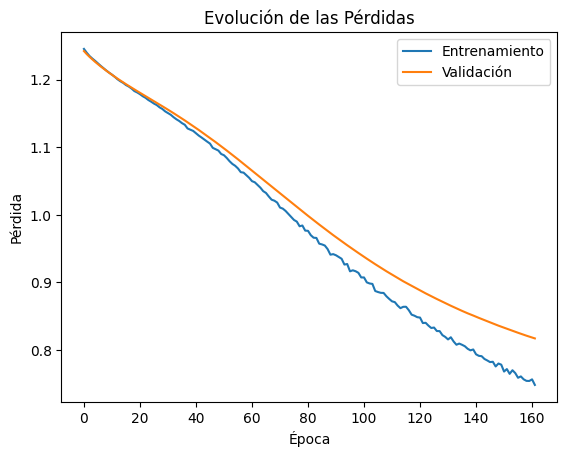

In [71]:
plt.plot(resultado.history["loss"], label="Entrenamiento")
plt.plot(resultado.history["val_loss"], label="Validación")
plt.title("Evolución de las Pérdidas")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()